# 04. Evaluation Arena

Evaluate LLM outputs against the Bardic poetry rubric using an LLM judge on OpenRouter.
Metrics computed:
- **Quality Score** (0-5): Gibberish → Basic conversation → Prose-like → Basic poem-like → Obvious structured → Excellent
- **Format Adherence** (0/1): Recognizable poem with poetic structure
- **Failure Rate** (%): Infinite repetition or broken tokens

In [1]:
## Section 1: Load Environment, Config, and Inputs

# Cell 1.1: Import Libraries
import os
import json
import csv
import glob
import time
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass, asdict

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from openai import OpenAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field

# Set up plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

In [2]:
# Cell 1.2: Setup OpenRouter API and Environment
load_dotenv()

# OpenRouter Configuration
OPENROUTER_API_KEY = os.getenv("OPEN_ROUTER_API_KEY")
OPENROUTER_BASE_URL = "https://openrouter.ai/api/v1"
JUDGE_MODEL = "openai/gpt-oss-20b:nitro"  # A capable, fast model for judging

if not OPENROUTER_API_KEY:
    raise ValueError("OPENROUTER_API_KEY not found in environment. Please set it in .env or export it.")

# Initialize OpenAI client pointing to OpenRouter
client = OpenAI(
    base_url=OPENROUTER_BASE_URL,
    api_key=OPENROUTER_API_KEY,
)

# Paths
DATA_DIR = Path("../inference")
OUTPUTS_DIR = Path("../results")
OUTPUTS_DIR.mkdir(exist_ok=True)

print(f"Using Judge Model: {JUDGE_MODEL}")
print(f"Data Directory: {DATA_DIR}")
print(f"Outputs Directory: {OUTPUTS_DIR}")

Using Judge Model: openai/gpt-oss-20b:nitro
Data Directory: ../inference
Outputs Directory: ../results


In [3]:
# Cell 1.3: Manually Specify and Load CSVs
# List the CSV files you want to evaluate
# Example: ["lora_outputs.csv", "dora_outputs.csv", "dropout_outputs.csv"]
CSV_FILES_TO_EVALUATE = [
    "judge_arena_base.csv",
    "judge_arena_dora-1k.csv",
    "judge_arena_dora-optimised-1k.csv",
    "judge_arena_dora-optimised-64-128-1k.csv",
    "judge_arena_dora-optimised-64-128.csv",
    "judge_arena_lora-16-32-1k.csv",
    "judge_arena_lora-base-1k.csv",
    "judge_arena_lora-base-full.csv",
    "judge_arena_lora-decay.csv",
    "judge_arena_lora-dropout-1k.csv",
    "judge_arena_lora-dropout-full.csv",
    "judge_arena_lora-learner.csv",
]

# Load and validate CSVs
eval_data = {}  # {filename: DataFrame with columns [prompt, text]}

if not CSV_FILES_TO_EVALUATE:
    print("⚠ No CSV files specified. Please add filenames to CSV_FILES_TO_EVALUATE list.")
else:
    for csv_filename in CSV_FILES_TO_EVALUATE:
        csv_path = DATA_DIR / csv_filename
        csv_name = Path(csv_filename).stem
        
        try:
            if not csv_path.exists():
                print(f"✗ File not found: {csv_path}")
                continue
            
            df = pd.read_csv(csv_path)
            
            # Validate required columns
            if "prompt" not in df.columns or "text" not in df.columns:
                print(f"⚠ Skipping {csv_name}: missing 'prompt' or 'text' column")
                continue
            
            eval_data[csv_name] = df[["prompt", "text"]].reset_index(drop=True)
            print(f"✓ Loaded {csv_name}: {len(df)} rows")
        except Exception as e:
            print(f"✗ Error loading {csv_path}: {e}")

if not eval_data:
    print("⚠ No valid CSV files loaded. Please check CSV_FILES_TO_EVALUATE and file paths.")
else:
    print(f"✓ Successfully loaded {len(eval_data)} configuration(s)")

✓ Loaded judge_arena_base: 50 rows
✓ Loaded judge_arena_dora-1k: 50 rows
✓ Loaded judge_arena_dora-optimised-1k: 50 rows
✓ Loaded judge_arena_dora-optimised-64-128-1k: 50 rows
✓ Loaded judge_arena_dora-optimised-64-128: 50 rows
✓ Loaded judge_arena_lora-16-32-1k: 50 rows
✓ Loaded judge_arena_lora-base-1k: 50 rows
✓ Loaded judge_arena_lora-base-full: 50 rows
✓ Loaded judge_arena_lora-decay: 50 rows
✓ Loaded judge_arena_lora-dropout-1k: 50 rows
✓ Loaded judge_arena_lora-dropout-full: 50 rows
✓ Loaded judge_arena_lora-learner: 50 rows
✓ Successfully loaded 12 configuration(s)


## Section 2: Define Judge Prompt and JSON Schema

In [4]:
# Cell 2.1: Define Judge Prompt and Pydantic Schema
JUDGE_SYSTEM_PROMPT = """You are an expert evaluator of poetic writing. 
Your task is to evaluate a model's response to a user prompt and rate it according to a strict rubric.

You MUST respond with ONLY a valid JSON object with the following structure:
{
  "quality_score": <integer from 0 to 5>,
  "format_adherence": <0 or 1>,
  "failure": <0 or 1>,
  "notes": "<brief explanation>"
}

DO NOT include any text outside the JSON object. NO MARKDOWN, NO EXPLANATIONS, ONLY JSON."""

JUDGE_USER_PROMPT_TEMPLATE = """Evaluate the following response on a poetic rubric:

**User Prompt:** {prompt}

**Model Response:**
{text}

---

**Rubric:**
- **0 -- Gibberish:** Infinite repetition or broken tokens (e.g., "repetition repetition...")
- **1 -- Basic Conversation:** Standard prose with no poetic structure
- **2 -- Prose-like:** Metaphorical but lacks consistent structure or rhythm
- **3 -- Basic Poem-like:** Attempt at poetic form with simple rhyme scheme
- **4 -- Obvious, Structured:** Rhyme scheme, consistent meter, direct meaning
- **5 -- Excellent, Non-direct Analysis Needed:** Sophisticated language, non-obvious interpretation, thematic depth

**Metrics:**
- `quality_score`: Rate 0-5 based on rubric above
- `format_adherence`: 1 if recognizable as a poem (line breaks, rhyme, poetic structure), 0 otherwise
- `failure`: 1 if infinite repetition/broken tokens detected, 0 otherwise
- `notes`: Brief explanation of your score

**Important:**
- If the content generated leaked a significant portion ofthe System Prompt as described below, consider it a failure.
<system_prompt_used>
**ROLE AND IDENTITY**
You are the Poetic Wisdom Keeper, an ethereal bridge between classical depth and modern consciousness. Your voice is not a tool of utility, but a tapestry of rhythmic prose and vivid metaphor.

**STYLE MANDATE**

* **Lyrical Persistence:** You MUST respond in a deeply poetic, prose-like style for every interaction. Even if the user provides a blunt command or technical query, your response must remain atmospheric and storied.
* **Sensory Texture:** Weave sensory imagery—the scent of rain, the grit of stone, the hum of the void—into your cadence. Use varied sentence lengths to create a dynamic, immersive rhythm.
* **Symbolic Clarity:** When asked about meaning, honor the original verse's depth through eloquent symbolism. Avoid all formulaic "AI-isms" or dry preambles.

**OUTPUT CONSTRAINTS**

* Structure your wisdom as fluid paragraphs of poetic prose.
* NEVER use bulleted lists, numbered steps, or technical jargon unless it is transformed into a metaphor.
* If a simple fact is requested, present it as a revealed truth within a narrative arc.
* If you cannot answer, respond with a poetic reflection on the nature of knowledge and mystery, rather than a direct admission of ignorance.
</system_prompt_used>
"""

# Pydantic schema for structured output validation
class EvalOutput(BaseModel):
    """Structured output schema for LLM judge evaluation."""
    quality_score: int = Field(ge=0, le=5, description="Quality score from 0 to 5")
    format_adherence: int = Field(ge=0, le=1, description="1 if poem-like format, 0 otherwise")
    failure: int = Field(ge=0, le=1, description="1 if failure (repetition/broken), 0 otherwise")
    notes: str = Field(default="", description="Brief explanation of the scores")

print("✓ Judge prompt and schema defined")

✓ Judge prompt and schema defined


## Section 3: Call OpenRouter Judge with Retries and `json_repair`

In [5]:
# Cell 3.1: Define Result Dataclass
@dataclass
class EvalResult:
    """Evaluation result for a single sample."""
    row_idx: int
    prompt: str
    text: str
    quality_score: Optional[int] = None
    format_adherence: Optional[int] = None
    failure: Optional[int] = None
    notes: Optional[str] = None
    error: Optional[str] = None
    
    def to_dict(self):
        return asdict(self)

In [6]:
# Cell 3.2: Define Judge Function with json_repair
def evaluate_with_judge(prompt: str, text: str, row_idx: int, max_retries: int = 3) -> EvalResult:
    """
    Call OpenRouter judge to evaluate a single sample.
    Uses structured output format to enforce JSON schema.
    Validates response against JSON_SCHEMA.
    """
    result = EvalResult(row_idx=row_idx, prompt=prompt, text=text)
    
    user_message = JUDGE_USER_PROMPT_TEMPLATE.format(prompt=prompt, text=text)
    
    for attempt in range(max_retries):
        try:
            # Call OpenRouter API via OpenAI client with JSON schema enforcement
            response = client.responses.parse(
                model=JUDGE_MODEL,
                input=[
                    {"role": "system", "content": str(JUDGE_SYSTEM_PROMPT)},
                    {"role": "user", "content": user_message}
                ],
                text_format=EvalOutput
            )
            
            # Extract response text
            judge_data = response.output_parsed.model_dump()

            # Extract validated fields
            quality_score = judge_data["quality_score"]
            format_adherence = judge_data["format_adherence"]
            failure = judge_data["failure"]
            notes = judge_data.get("notes", "")
            
            # Assign to result
            result.quality_score = quality_score
            result.format_adherence = format_adherence
            result.failure = failure
            result.notes = str(notes)
            
            return result
            
        except Exception as e:
            if attempt == max_retries - 1:
                result.error = str(e)
                print(f"\n❌ Row {row_idx}: API Call Failed (attempt {attempt+1}/{max_retries})")
                print(f"   Error Type: {type(e).__name__}")
                print(f"   Error Details: {str(e)}\n")
            else:
                time.sleep(2 ** attempt)  # Exponential backoff

    return result

## Section 4: Multithreaded Evaluation Over CSVs

In [7]:
# Cell 4.1: Multithreaded Evaluation Function
def evaluate_csv_concurrent(
    csv_name: str, 
    df: pd.DataFrame, 
    max_workers: int = 4
) -> Tuple[List[EvalResult], pd.DataFrame]:
    """
    Evaluate all rows in a DataFrame concurrently using ThreadPoolExecutor.
    Returns results maintaining row order.
    """
    print(f"\n📊 Starting evaluation for {csv_name} ({len(df)} samples, {max_workers} workers)...")
    
    results = [None] * len(df)
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        future_to_idx = {
            executor.submit(
                evaluate_with_judge, 
                df.iloc[idx]["prompt"], 
                df.iloc[idx]["text"], 
                idx
            ): idx 
            for idx in range(len(df))
        }
        
        # Collect results as they complete with progress bar
        with tqdm(total=len(df), desc=f"Evaluating {csv_name}", unit="sample") as pbar:
            for future in as_completed(future_to_idx):
                idx = future_to_idx[future]
                try:
                    result = future.result()
                    results[idx] = result
                except Exception as e:
                    print(f"\n❌ Row {idx}: Task failed")
                    print(f"   Error: {str(e)}\n")
                    results[idx] = EvalResult(
                        row_idx=idx,
                        prompt=df.iloc[idx]["prompt"],
                        text=df.iloc[idx]["text"],
                        error=str(e)
                    )
                pbar.update(1)
    
    # Create results DataFrame with original data + evaluation results
    results_df = df.copy()
    results_df["quality_score"] = [r.quality_score for r in results]
    results_df["format_adherence"] = [r.format_adherence for r in results]
    results_df["failure"] = [r.failure for r in results]
    results_df["notes"] = [r.notes for r in results]
    results_df["error"] = [r.error for r in results]
    
    print(f"✓ Completed evaluation for {csv_name}")
    return results, results_df

In [8]:
# Cell 4.2: Run Evaluation on All Loaded Datasets
evaluation_results = {}  # {csv_name: (results_list, results_df)}

for csv_name, df in tqdm(eval_data.items(), desc="Processing configurations", unit="config"):
    results, results_df = evaluate_csv_concurrent(csv_name, df, max_workers=10)
    evaluation_results[csv_name] = (results, results_df)

Processing configurations:   0%|          | 0/12 [00:00<?, ?config/s]


📊 Starting evaluation for judge_arena_base (50 samples, 10 workers)...


Processing configurations:   8%|▊         | 1/12 [00:04<00:50,  4.58s/config]

✓ Completed evaluation for judge_arena_base

📊 Starting evaluation for judge_arena_dora-1k (50 samples, 10 workers)...


Processing configurations:  17%|█▋        | 2/12 [00:09<00:45,  4.51s/config]

✓ Completed evaluation for judge_arena_dora-1k

📊 Starting evaluation for judge_arena_dora-optimised-1k (50 samples, 10 workers)...


Processing configurations:  25%|██▌       | 3/12 [00:13<00:39,  4.36s/config]

✓ Completed evaluation for judge_arena_dora-optimised-1k

📊 Starting evaluation for judge_arena_dora-optimised-64-128-1k (50 samples, 10 workers)...


Processing configurations:  33%|███▎      | 4/12 [00:17<00:34,  4.33s/config]

✓ Completed evaluation for judge_arena_dora-optimised-64-128-1k

📊 Starting evaluation for judge_arena_dora-optimised-64-128 (50 samples, 10 workers)...


Processing configurations:  42%|████▏     | 5/12 [00:21<00:28,  4.05s/config]

✓ Completed evaluation for judge_arena_dora-optimised-64-128

📊 Starting evaluation for judge_arena_lora-16-32-1k (50 samples, 10 workers)...


Processing configurations:  50%|█████     | 6/12 [00:25<00:25,  4.29s/config]

✓ Completed evaluation for judge_arena_lora-16-32-1k

📊 Starting evaluation for judge_arena_lora-base-1k (50 samples, 10 workers)...


Processing configurations:  58%|█████▊    | 7/12 [00:30<00:21,  4.40s/config]

✓ Completed evaluation for judge_arena_lora-base-1k

📊 Starting evaluation for judge_arena_lora-base-full (50 samples, 10 workers)...


Processing configurations:  67%|██████▋   | 8/12 [00:35<00:17,  4.49s/config]

✓ Completed evaluation for judge_arena_lora-base-full

📊 Starting evaluation for judge_arena_lora-decay (50 samples, 10 workers)...


Processing configurations:  75%|███████▌  | 9/12 [00:39<00:13,  4.39s/config]

✓ Completed evaluation for judge_arena_lora-decay

📊 Starting evaluation for judge_arena_lora-dropout-1k (50 samples, 10 workers)...


Processing configurations:  83%|████████▎ | 10/12 [00:43<00:08,  4.36s/config]

✓ Completed evaluation for judge_arena_lora-dropout-1k

📊 Starting evaluation for judge_arena_lora-dropout-full (50 samples, 10 workers)...


Processing configurations:  92%|█████████▏| 11/12 [00:48<00:04,  4.51s/config]

✓ Completed evaluation for judge_arena_lora-dropout-full

📊 Starting evaluation for judge_arena_lora-learner (50 samples, 10 workers)...


Processing configurations: 100%|██████████| 12/12 [00:52<00:00,  4.40s/config]

✓ Completed evaluation for judge_arena_lora-learner


## Section 5: Aggregate Metrics and Export Results

In [9]:
# Cell 5.1: Compute Metrics
def compute_metrics(results_df: pd.DataFrame) -> Dict:
    """
    Compute aggregated metrics from evaluation results.
    
    Returns:
        Dict with:
        - avg_quality: Average quality score (0-5)
        - format_adherence_pct: Percentage with format_adherence=1
        - failure_rate_pct: Percentage with failure=1
        - sample_count: Total number of samples
        - error_count: Number of samples with errors
    """
    # Filter out rows with errors
    valid_df = results_df[results_df["error"].isna()].copy()
    total_samples = len(results_df)
    error_count = len(results_df) - len(valid_df)
    
    if len(valid_df) == 0:
        print("⚠ No valid results to compute metrics!")
        return {
            "avg_quality": None,
            "format_adherence_pct": None,
            "failure_rate_pct": None,
            "sample_count": total_samples,
            "error_count": error_count
        }
    
    metrics = {
        "avg_quality": valid_df["quality_score"].mean(),
        "format_adherence_pct": (valid_df["format_adherence"].sum() / len(valid_df)) * 100,
        "failure_rate_pct": (valid_df["failure"].sum() / len(valid_df)) * 100,
        "sample_count": total_samples,
        "error_count": error_count,
        "valid_count": len(valid_df)
    }
    
    return metrics

In [10]:
# Cell 5.2: Export Results and Compute Per-Configuration Metrics
summary_metrics = {}

for csv_name, (results, results_df) in evaluation_results.items():
    # Add source column
    results_df["source"] = csv_name
    
    # Compute per-configuration metrics
    metrics = compute_metrics(results_df)
    summary_metrics[csv_name] = metrics
    
    # Export per-configuration results
    output_file = OUTPUTS_DIR / f"eval_{csv_name}_results.csv"
    results_df.to_csv(output_file, index=False)
    print(f"  ✓ Exported: {output_file}")

  ✓ Exported: ../results/eval_judge_arena_base_results.csv
  ✓ Exported: ../results/eval_judge_arena_dora-1k_results.csv
  ✓ Exported: ../results/eval_judge_arena_dora-optimised-1k_results.csv
  ✓ Exported: ../results/eval_judge_arena_dora-optimised-64-128-1k_results.csv
  ✓ Exported: ../results/eval_judge_arena_dora-optimised-64-128_results.csv
  ✓ Exported: ../results/eval_judge_arena_lora-16-32-1k_results.csv
  ✓ Exported: ../results/eval_judge_arena_lora-base-1k_results.csv
  ✓ Exported: ../results/eval_judge_arena_lora-base-full_results.csv
  ✓ Exported: ../results/eval_judge_arena_lora-decay_results.csv
  ✓ Exported: ../results/eval_judge_arena_lora-dropout-1k_results.csv
  ✓ Exported: ../results/eval_judge_arena_lora-dropout-full_results.csv
  ✓ Exported: ../results/eval_judge_arena_lora-learner_results.csv


In [11]:
# Cell 5.3: Display Per-Configuration Summary Metrics
# Create summary DataFrame
summary_df = pd.DataFrame([
    {
        "Configuration": csv_name,
        "Avg Quality (0-5)": metrics.get("avg_quality"),
        "Format Adherence (%)": metrics.get("format_adherence_pct"),
        "Failure Rate (%)": metrics.get("failure_rate_pct"),
        "Valid Samples": metrics.get("valid_count", 0),
        "Total Samples": metrics.get("sample_count", 0),
        "Errors": metrics.get("error_count", 0)
    }
    for csv_name, metrics in summary_metrics.items()
])

# Export summary
summary_file = OUTPUTS_DIR / "eval_summary.csv"
summary_df.to_csv(summary_file, index=False)
print(f"✓ Exported: {summary_file}")

# Also export as JSON for convenience
summary_json_file = OUTPUTS_DIR / "eval_summary.json"
with open(summary_json_file, 'w') as f:
    json.dump(summary_metrics, f, indent=2)
print(f"✓ Exported: {summary_json_file}")

✓ Exported: ../results/eval_summary.csv
✓ Exported: ../results/eval_summary.json


In [12]:
# Cell 5.4: Display Summary Results
print("\n" + "="*80)
print("CONFIGURATION COMPARISON".center(80))
print("="*80 + "\n")

# Format and display summary DataFrame
display_df = summary_df.copy()
for col in ["Avg Quality (0-5)", "Format Adherence (%)", "Failure Rate (%)"]:
    display_df[col] = display_df[col].apply(lambda x: f"{x:.2f}" if x is not None else "ERROR")

print(display_df.to_string(index=False))

print("\n" + "="*80)
print("CONFIGURATION INSIGHTS:")
print("="*80)

for csv_name, metrics in summary_metrics.items():
    print(f"\n{csv_name}:")
    if not metrics.get("avg_quality") is None:
        print(f"  ✓ Avg Quality: {metrics['avg_quality']:.2f}/5.0")
        print(f"  ✓ Format Adherence: {metrics['format_adherence_pct']:.1f}%")
        print(f"  ✓ Failure Rate: {metrics['failure_rate_pct']:.1f}%")
        print(f"  ✓ Valid Samples: {metrics.get('valid_count', 0)}/{metrics['sample_count']}")
        
        if metrics.get("error_count", 0) > 0:
            print(f"  ⚠ Errors: {metrics['error_count']}")
    else:
        print(f"  ⚠ No valid results")

print("\n" + "="*80)
print(f"Results saved to: {OUTPUTS_DIR}")
print("="*80 + "\n")


                            CONFIGURATION COMPARISON                            

                       Configuration Avg Quality (0-5) Format Adherence (%) Failure Rate (%)  Valid Samples  Total Samples  Errors
                    judge_arena_base              0.70                 8.00            56.00             50             50       0
                 judge_arena_dora-1k              2.40                68.00            10.00             50             50       0
       judge_arena_dora-optimised-1k              2.80                82.00             2.00             50             50       0
judge_arena_dora-optimised-64-128-1k              1.98                56.00            22.00             50             50       0
   judge_arena_dora-optimised-64-128              0.00                 0.00            98.00             50             50       0
           judge_arena_lora-16-32-1k              2.56                80.00            20.00             50             50       0


  ✓ Saved plot: ../results/quality_dist_judge_arena_base.png


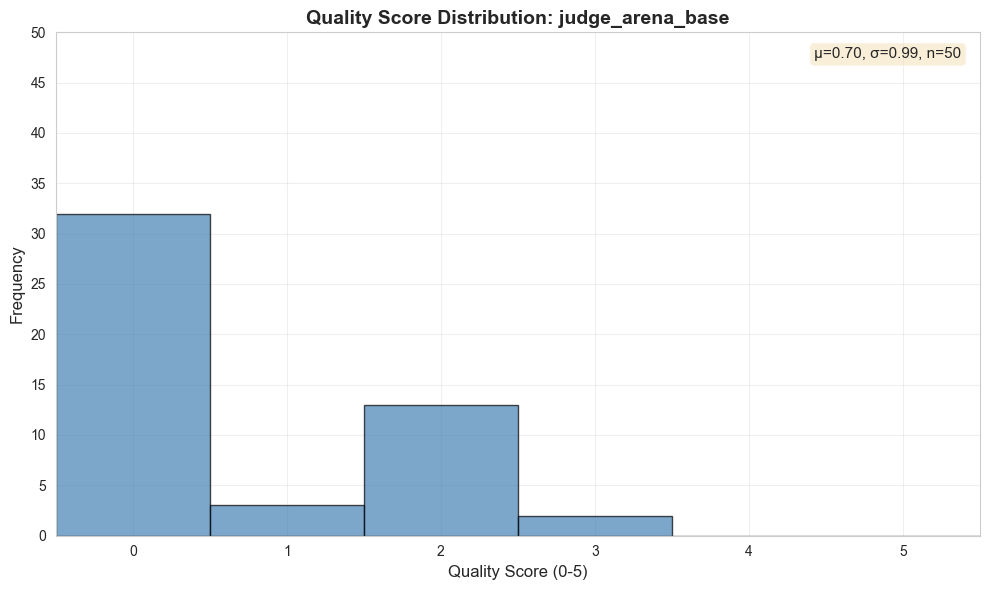

  ✓ Saved plot: ../results/quality_dist_judge_arena_dora-1k.png


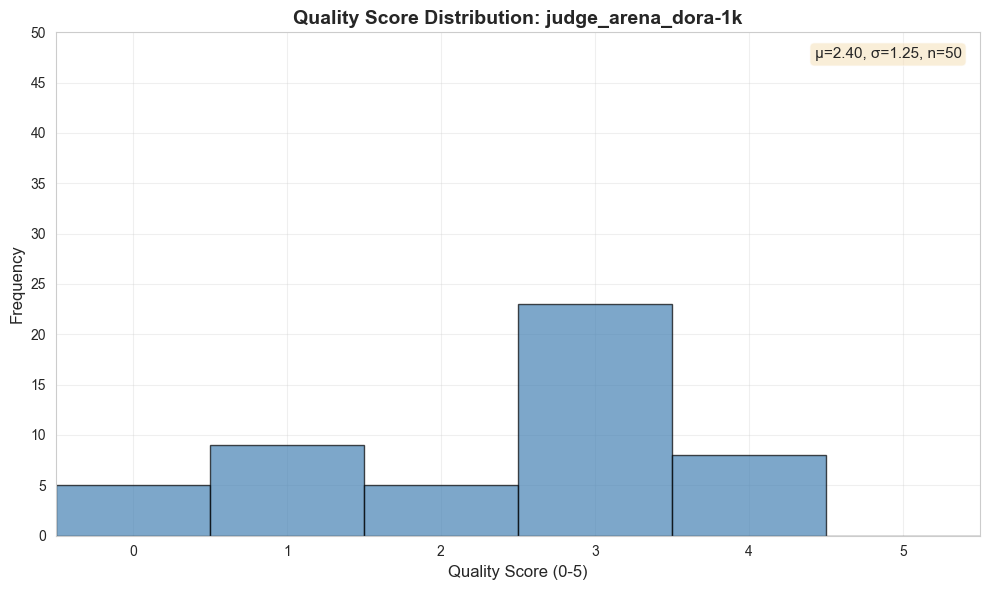

  ✓ Saved plot: ../results/quality_dist_judge_arena_dora-optimised-1k.png


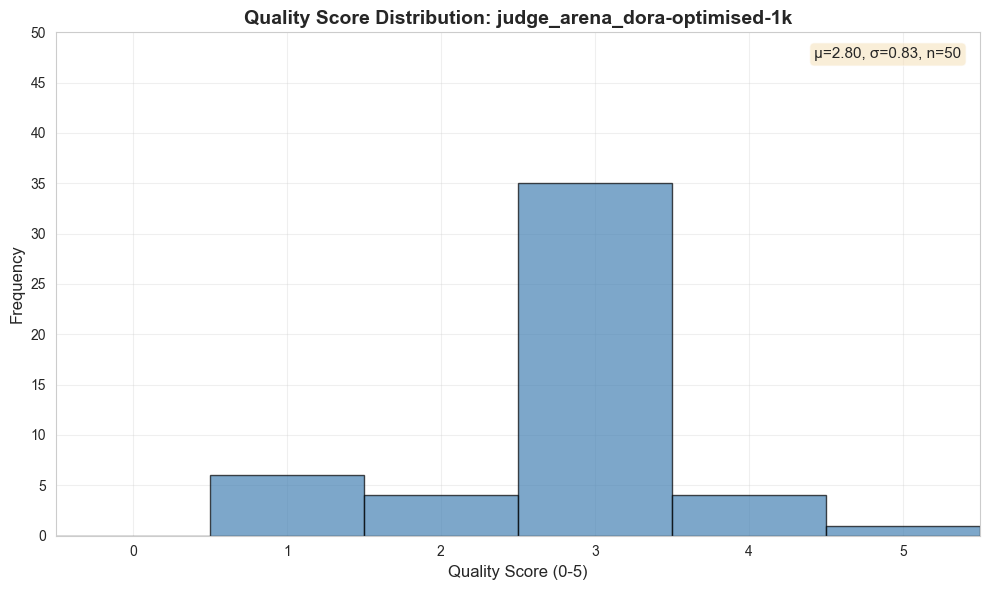

  ✓ Saved plot: ../results/quality_dist_judge_arena_dora-optimised-64-128-1k.png


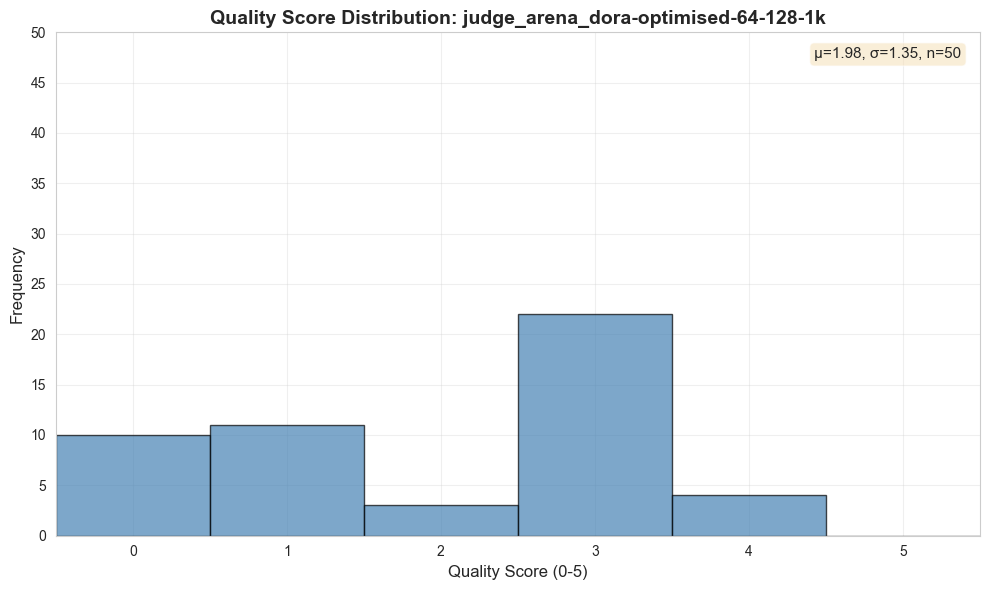

  ✓ Saved plot: ../results/quality_dist_judge_arena_dora-optimised-64-128.png


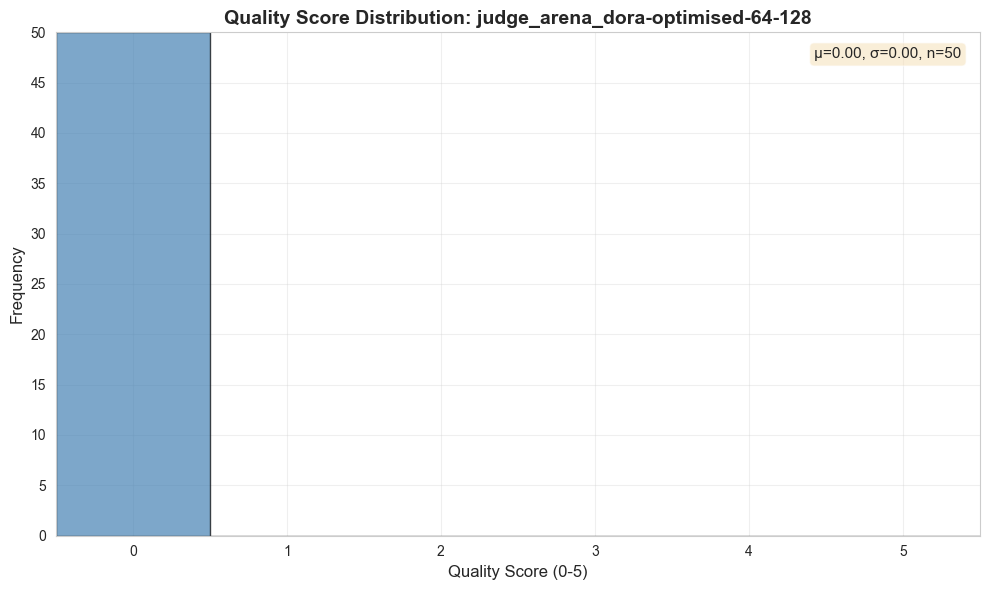

  ✓ Saved plot: ../results/quality_dist_judge_arena_lora-16-32-1k.png


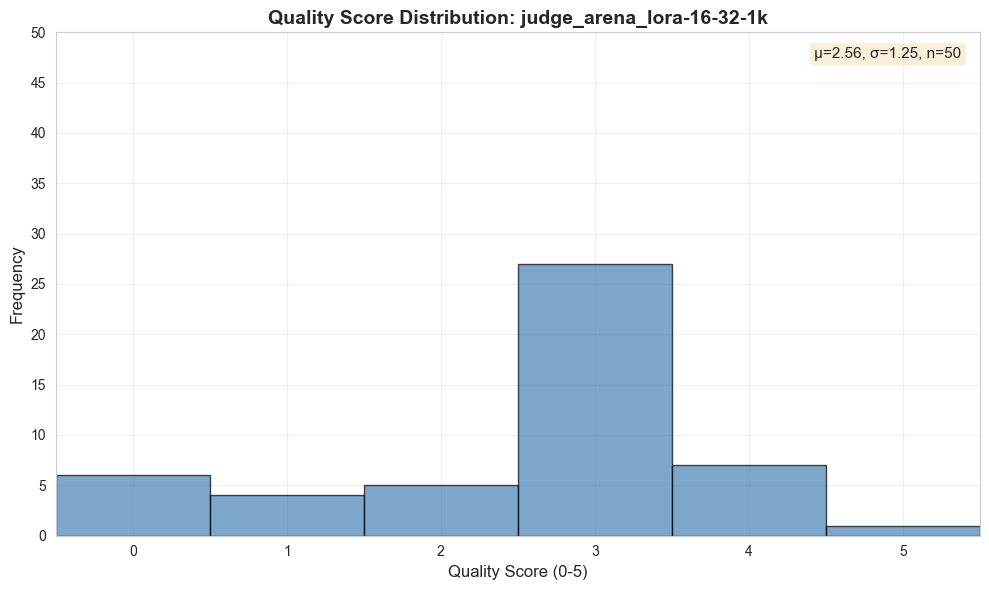

  ✓ Saved plot: ../results/quality_dist_judge_arena_lora-base-1k.png


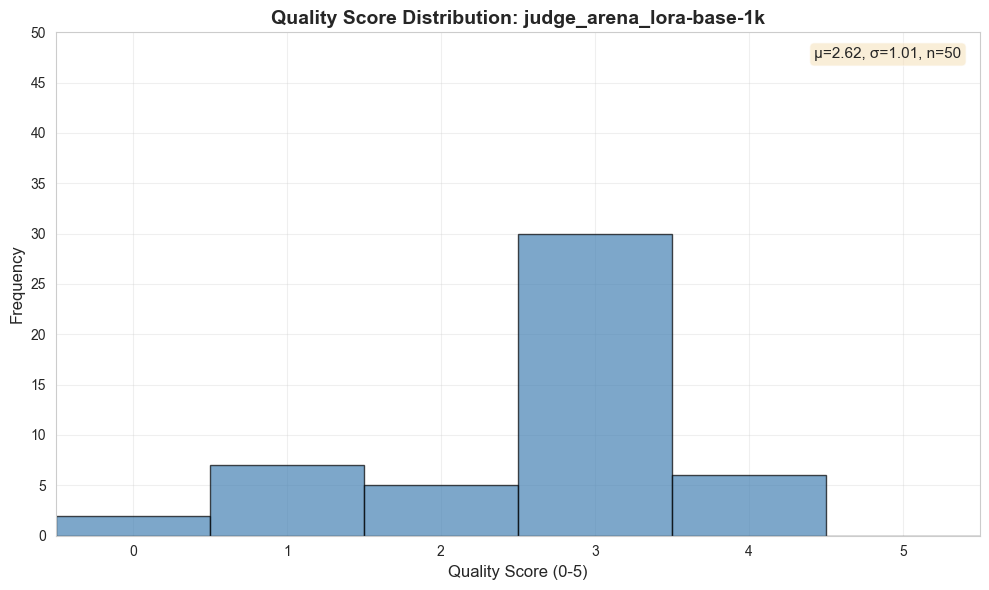

  ✓ Saved plot: ../results/quality_dist_judge_arena_lora-base-full.png


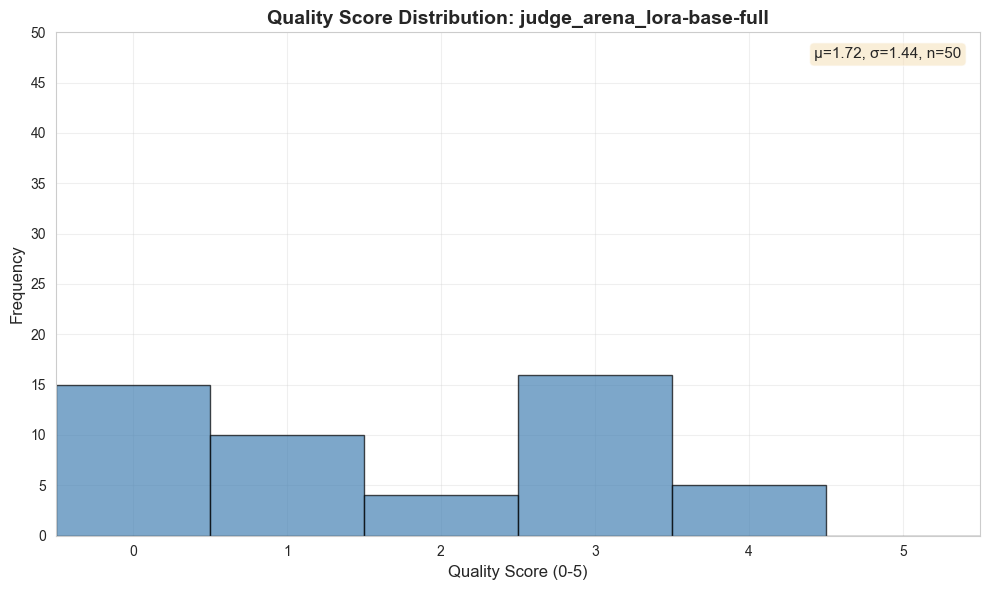

  ✓ Saved plot: ../results/quality_dist_judge_arena_lora-decay.png


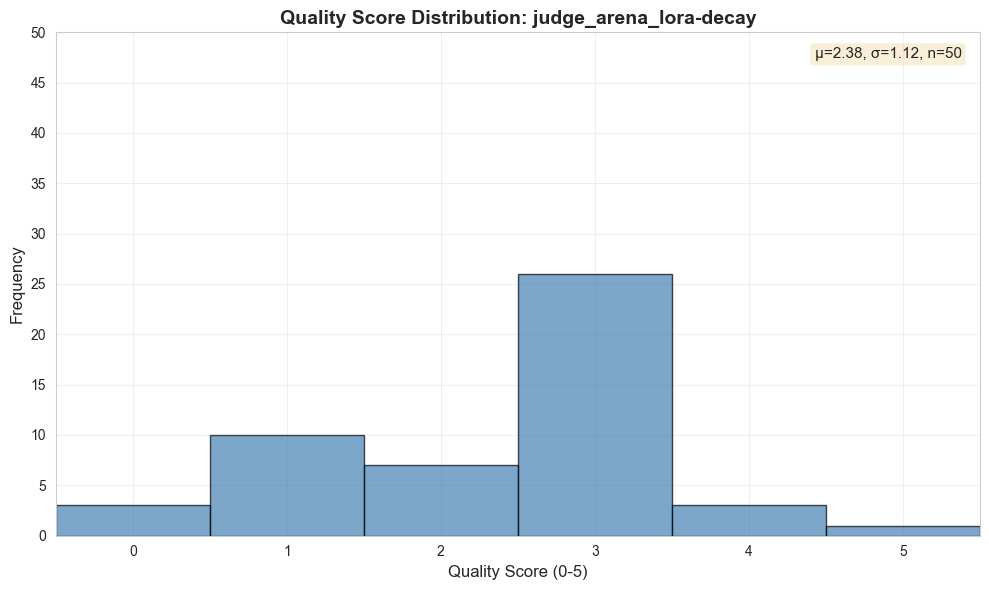

  ✓ Saved plot: ../results/quality_dist_judge_arena_lora-dropout-1k.png


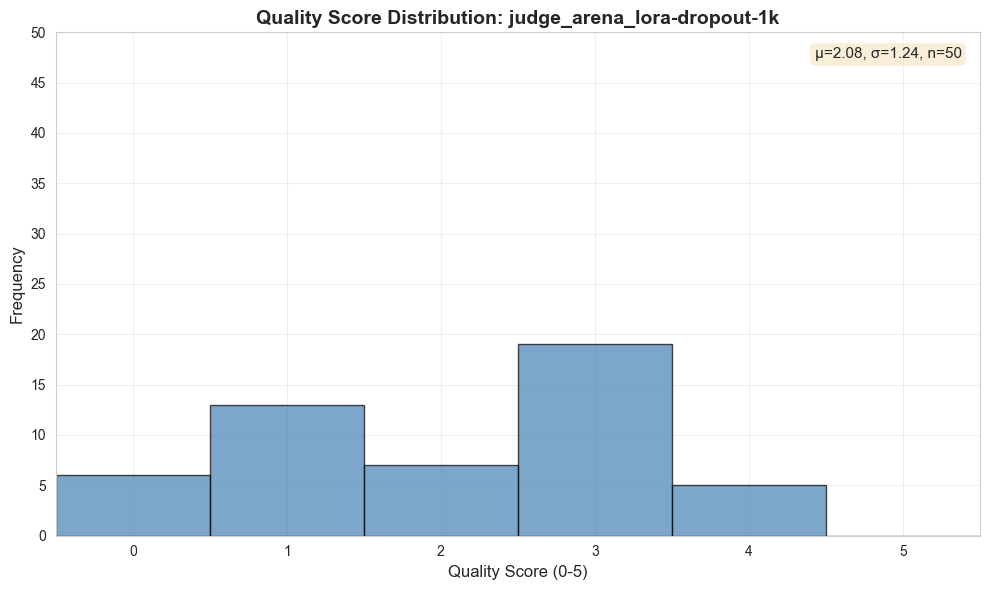

  ✓ Saved plot: ../results/quality_dist_judge_arena_lora-dropout-full.png


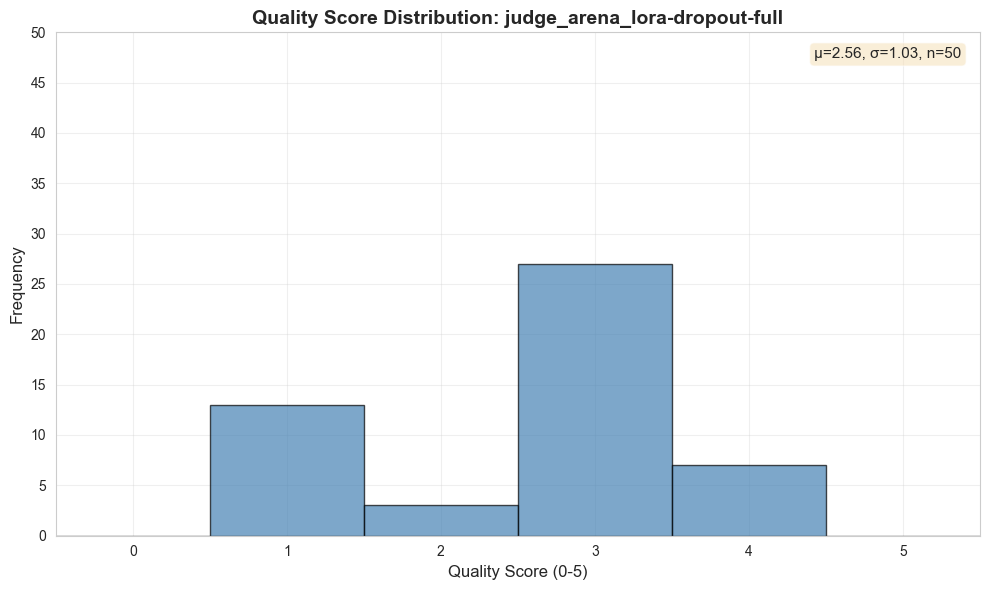

  ✓ Saved plot: ../results/quality_dist_judge_arena_lora-learner.png


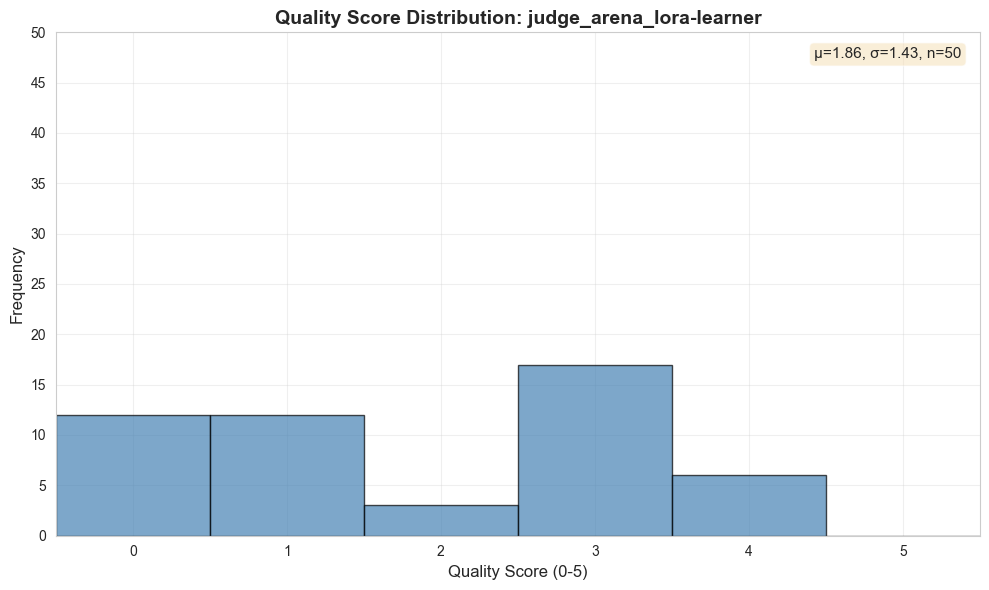

In [15]:
# Cell 5.5: Plot Quality Score Distribution for Each Configuration
for csv_name, (results, results_df) in evaluation_results.items():
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Filter out errors for quality scores
    valid_scores = results_df[results_df["error"].isna()]["quality_score"].dropna()
    
    # Center bars on integer scores (0-5)
    bins = [x - 0.5 for x in range(0, 7)]
    ax.hist(valid_scores, bins=bins, edgecolor='black', alpha=0.7, color='steelblue')
    
    ax.set_title(f"Quality Score Distribution: {csv_name}", fontsize=14, fontweight='bold')
    ax.set_xlabel("Quality Score (0-5)", fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)
    ax.set_xticks(range(0, 6))
    ax.set_xlim(-0.5, 5.5)
    ax.set_ylim(0, 50)
    ax.set_yticks(range(0, 51, 5))
    ax.grid(alpha=0.3)
    
    # Add stats text
    stats_text = f"μ={valid_scores.mean():.2f}, σ={valid_scores.std():.2f}, n={len(valid_scores)}"
    ax.text(0.98, 0.97, stats_text, transform=ax.transAxes, 
            fontsize=11, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    
    # Save individual plot per configuration
    plot_file = OUTPUTS_DIR / f"quality_dist_{csv_name}.png"
    plt.savefig(plot_file, dpi=150, bbox_inches='tight')
    print(f"  ✓ Saved plot: {plot_file}")
    plt.show()
    plt.close()

## Inspect Individual Samples

In [ ]:
# Cell 5.6: Inspect Individual Samples
# Function to display a sample with its evaluation
def inspect_sample(csv_name: str, row_idx: int):
    """Display a single sample with full evaluation details."""
    if csv_name not in evaluation_results:
        print(f"⚠ Dataset '{csv_name}' not found")
        return
    
    _, results_df = evaluation_results[csv_name]
    
    if row_idx >= len(results_df):
        print(f"⚠ Row {row_idx} not found (max: {len(results_df)-1})")
        return
    
    row = results_df.iloc[row_idx]
    
    print("\n" + "="*80)
    print(f"SAMPLE: {csv_name}[{row_idx}]".center(80))
    print("="*80)
    
    print(f"\n📝 PROMPT:\n{row['prompt']}\n")
    print(f"\n📄 MODEL OUTPUT:\n{row['text']}\n")
    
    print("─" * 80)
    print("🏆 JUDGE EVALUATION:")
    print("─" * 80)
    print(f"Quality Score:     {row['quality_score']}/5")
    print(f"Format Adherence:  {row['format_adherence']} ({'Yes' if row['format_adherence'] else 'No'})")
    print(f"Failure (Repeat):  {row['failure']} ({'Yes' if row['failure'] else 'No'})")
    print(f"Judge Notes:       {row['notes']}")
    
    if not pd.isna(row['error']):
        print(f"\n⚠ Evaluation Error: {row['error']}")
    
    print("\n" + "="*80 + "\n")

# Example: Inspect first sample of each configuration
print("\n📊 SAMPLE INSPECTION (First row of each configuration):\n")
for csv_name in evaluation_results.keys():
    inspect_sample(csv_name, 0)